## FIT5226 Assignment 2 Team (TBA)
MEMBERS :
- Michelle Adeline (31989101)
- Pay Quan Bi (31248403)
- Chan Jia Zheng (32223315)
- Zoe Low Pei Ee (31989985)

TUTOR : Dr. Fuad Noman

## Imports

In [1]:
# loads classes and functions to implement task
from modules.env import Environment
from modules.history import History
from modules.agent_movement import Agent, Movement, MoveDown, MoveLeft, MoveRight, MoveUp
from modules.reward import Reward
from modules.engine import Engine
from modules.qlearning import QLearning, DeepQLearning
from modules.policies import Boltzmann, EpsilonGreedy, Pursuit, MonteCarlo
from modules.losses import L2_Loss, L1_Loss
from modules.constants import *
from modules.viz import Visualization
from modules.search import hyperparam_search
from modules.grid_test import test_grids, test_grids_viz
from modules.model import Baseline, Dueling, QNetwork

# import libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.optim as optim
import torch.nn as nn

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Environment

To implement the GRID WORLD that is scalable and generalisable, Object-Oriented Programming (OOP) concepts are applied in the design. To follow Separation of Concerns, our design is modularised and consists of the following 2 main classes:
- `Environment` (A class for generating the grids and simulate the environment) located [**here**](modules/env.py)
- `Agent` (A class for mimicking the agent to perform actions in the environment) located [**here**](modules/agent_movement.py)

To modularize the components, supported classes are created to allow flexibility and scalability. The following shows some of the supported classes.
- `History` (A class used to keep track of the states, actions, rewards in each episode) located [**here**](modules/history.py)
- `Movement` (A class used for representing the action space) located [**here**](modules/agent_movement.py)

In order to create a scalable solution, we have listed the main measures taken to implement this below:
- `Environment` class
    - accepts a `grid_size` parameter which is used to create a grid world of any (width, height)
    - `loc_agent`, `loc_a`, `loc_b` as optional parameters, if any of the locations are provided then they are fixed throughout the task, thus the code is generalizable to fixed agent or A locations, as well as randomly generated locations
    - allows resetting (see `reset` method) which will re-generate the grid world with random agent, A, and B locations (if they are not fixed) while also allowing the option to fix the agent, A, B locations for a particular run (for evaluation)
- `Agent` class
    - has an `env` attribute which allows it to stay in sync with the environment configuration, possible movements are ascertained by the environment so that the agent automatically adapts to any grid world

This gives an overview of the design which is greatly modularized to ensure great scalability. For details of the implementation, refer to the implementation files.

## Task Description

The Q-agent must learn to navigate in a grid world, it succeeds in its task by first picking up the item at location A (by simply reaching location A), and delivering it to location B (by simply reaching location B *after* picking up item at A). It must be able to perform this task regardless of the initial location of the agent or location A or location B. In other words, all initial locations are randomly generated for every episode.

### State space
In order to be able to reuse learned q-values between episodes, we have formulated our state as the (x,y) position relative to the target (A/B). 

Let (u, v) be state.  
Let (x, y) be grid size.  

Based on our implementation:
1. u is the horizontal position of agent with respect to the target (A/B). u ∈ (-(x-1), (x-1))
2. v is the vertical position of the agent with respect to the target (A/B). v ∈ (-(y-1), (y-1))
3. Position of target relative to itself is at (0 ,0) 

Note that the target is initialized to A at the beginning of an episode and is changed to B once the agent picks up the item at A, thus our state automatically adapts to this change in target.

For an example of why this is effective, if we imagine that the agent is directly to the left of location A, the best action will always be to move right and pick up the item at A regardless of their actual grid positions (i.e. even if the agent and location A are in the left, center, right or anywhere else in the grid world, the best action is still to move right). Our engineered state reflects this by treating all these scenarios with the same state (-1,0) which tells the agent that it is 1 cell to the left of the target.

### Action space
Our Q-Agent can move in the four cardinal directions -- Up, Down, Left, Right.

However, if it is adjacent to one or more of the four corners of the grid world, then its movements are limited. For example, if it is adjacent to the right corner of the grid world, it cannot move Right (since then it would move off the map!)

Note that the following measure has been taken to implement a scalable solution:
- `Movement` class
    - agents will check for subclasses of `Movement`, thus if we want to add another movement to the task, we can simply inherit `Movement` class and all agents will be able to use this movement without changing the `Agent` code at all!

In [4]:
history = History()
eval_history = History()
env = Environment((4,4), history)
agent = Agent(env)

## Deep Q-Netwok

A Deep Q-Network (DQN) is a reinforcement learning algorithm that combines deep neural networks with Q-learning, a popular tabular algorithm for solving Markov decision processes. The main idea behind DQN is to use a deep neural network to approximate the Q-values by stochastic gradient descent, which represent the expected future rewards for taking different actions in a given state. The following describes few important elements in Deep Q-Network

### Q-Value Update

In general, the optimal action-value function obeys the Bellman Equation which is based on the following intuition: If the optimal value, $Q^{*}(s', a')$ of the sequence $s'$ at the next time-step was known for all possible actions $a'$, then the optimal strategy is to select the action $a'$ which maximizes the expected value $r + \gamma Q^{*}(s', a')$. Mathematically speaking, we have

\begin{equation*}
    Q^{*}(s, a) = \mathbb{E}_{s' \sim \varepsilon}[r + \gamma \max_{a'} Q^{*}(s', a') \; | \; s, a]
\end{equation*}

Unlike the tabular Q-learning which uses Bellman equation for iterative update such that

\begin{equation*}
    Q_{i+1}(s, a) = \mathbb{E}[r + \gamma \max_{a'} Q_{i}(s', a') \; | \; s, a]
\end{equation*}

DQN with parameters $\theta$ is trained by minimising a sequence of loss function, $L_i(\theta_i)$ which changes at each iteration

\begin{equation*}
    L_i(\theta_i) = \mathbb{E}_{s, a \sim \rho (\cdot)}[(y_i - Q(s, a;\theta_i))^2]
\end{equation*}

where 

\begin{equation*}
    y_i = \mathbb{E}_{s' \sim \varepsilon}[r + \gamma max_{a'} Q(s', a'; \theta_{i-1})\;|\;s, a]
\end{equation*}

is the target for iteration $i$ and $\rho(s, a)$ is a probability distribution over sequences $s$ and actions $a$ that we refer to behaviour distribution. The parameters from the previous iteration $\theta_{i-1}$ are held fixed when optimising the loss function $L_i(\theta_i)$ to emulate fixed target in conventional supervised learning. With that, differentiating the loss function, we obtain an update gradient as follows.

\begin{equation*}
    \mathbb{E}_{s, a \sim \rho (\cdot); s' \sim \varepsilon}[(r + \gamma max_{a'} Q(s', a';\theta_{i-1} - Q(s, a; \theta_i))\Delta_{\theta_i}Q(s, a;\theta_i)]
\end{equation*}

From the above equation, we note that DQN agent updates its Q-network by minimizing the mean squared error between the predicted Q-values and the target Q-values. Note the target Q-values are dependent on the weights of the network weights, resulting in unstable learning at each update. To address the issue, a target network which is a separate network but with the same initialized weights as the network is created and periodically updated to match the weights of the network in order to simulate the effect of policy iteration. In practice the behavioural distribution, $\varepsilon$ is selected to follow $\epsilon$-greedy policy.

### Experience Replay

Instead of conduct the weights update incrementally on a single sample as in Tabular Q-Learinng, experience replay is introduced to improve the training stability by reducing correlation between consecutive samples while also allowing a single batch update. 

The idea is simple such that batches of states, actions and rewards are randomly sampled from the past experience and used in updating the weights of the network. Through random sampling, temporal correlation in the agent's experiences are disrupted and hence agent is exposed to more diverse set of experiences which greatly reduces the bias and variance during learning. On the other hand, sampling from past experiences allows a good trade-off between exploration and exploitation as agent may utilize important experiences which may not necessarily be recent. With that, the training could be stabilized with less dependent relationship between the order of encountered experiences.

### Double Q-Learning Variant

In tabular method, a double q-learning would maintain 2 sets of Q values, namely $Q_1(s, a)$ and $Q_2(s, a)$. The idea is to create an unbiased estimator from the 2 sets of Q values. The update rule would be as follows.

\begin{align*}
    Q_1(s, a) &\leftarrow{} Q_1(s, a) + \alpha (r + \gamma Q_2(s', \arg\max_a Q_1(s', a)) - Q_1(s, a)) \\
    Q_2(s, a) &\leftarrow{} Q_2(s, a) + \alpha (r + \gamma Q_1(s', \arg\max_a Q_2(s', a)) - Q_2(s, a))
\end{align*}

The 2 update rules are interleave with a predefined probability. Transfering the knowledge to Deep Q-Network, we could rewrite the evaluation of DQN target to be

\begin{equation*}
    y_i = \mathbb{E}_{s' \sim \varepsilon}[r + \gamma Q(s', max_{a'} Q(s', a'; \theta_{i-1}); \theta_{i-1})\;|\;s, a]
\end{equation*}

Replacing $y_i$ to the loss gradient function in DQN above, we obtain an update gradient as follows.

\begin{equation*}
    \mathbb{E}_{s, a \sim \rho (\cdot); s' \sim \varepsilon}[(r + \gamma Q(s', max_{a'} Q(s', a';\theta_{i-1}); \theta_{i-1}) - Q(s, a; \theta_i))\Delta_{\theta_i}Q(s, a;\theta_i)]
\end{equation*}

Since we require 2 models, namely target and prediction model, Double DQN could be easily realized by replacing the update rule in existing implementation without any modification on the network structure. However, such simple idea could reduce overoptimism in the estimate of DQN and find a better policy as compared to DQN.

### Implementation

In our implementation, to accommodate the dual network training scheme, we have maintain 2 models, namely prediction and target network which share the same structure and same weights during initialization. Furthermore, with our states being the Manhattan distance from the target location, our model is kept minimally simple with 3 linear layers with ReLU activation function. Following the convention, $\epsilon$-greedy policy is chosen as the behavioral distribution scheme. However, for experimental purpose, the number of layers, type of activation function and behavioral policy could be changed due to the flexible implementation.

Also, note that the above update rule is based on Mean-Squared Error. However, in our implementation, we have chosen SmoothL1Loss, defined as

\begin{equation*}
    L(\hat{y}, y) = \begin{cases}
        \frac{0.5(\hat{y} - y)^2}{\beta} & \text{ if } |\hat{y} - y| < \beta \\
        |\hat{y} - y| - 0.5\beta & \text{ otherwise}
    \end{cases}
\end{equation*}

to be our loss function for updating the weights as we find that it greatly match with the state representation and would provide a better training convergeance.

In our implementation, instead of sampling from the whole past experience, we only allow the replay buffer to store the experiences that minimally exceed the batch size for every episodes. This would ensure the efficient use of memory and reduce the time complexity of sampling from numerous experiences. However, this comes with a minor drawback such that the training convergeance is slower as compared to larger buffer memory. For further details, please refer to the relevant classes stated below.

Relevant classes are:
- `Learning` (A class for implementing the learning mechanism, i.e. Q-Learning) located [**here**](modules/qlearning.py)
- `QNetwork` (A class for implementing the Deep Q-Network design) located [**here**](modules/model.py)
- `Engine` (A class for running simulation, either training or evaluating the agent) located [**here**](modules/engine.py)
- `Policy` (A class for implementing the behavioural policy used in Q-Learning) located [**here**](modules/policies.py)

### Reward Structure

Our reward structure consists of 2 components, namely TARGET REWARD and BASE REWARD. TARGET REWARD would be given when the agent successfully reaches point A and B respectively (*Note: If agent reaches B before picking up A, it does not get the TARGET REWARD*). On the other hand, BASE REWARD is awarded for making any move which lands the agent on a non-target grid cell.

Setting BASE REWARD and TARGET REWARD to be negative and positive values respectively, -1 and 10, would encourage the agent to search for the point A and B as soon as possible for maximizing the expected rewards. However, such a simple strategy does not allow the agent to learn the policy efficiently and hence additional penalty is incurred when the agent revisits the same state, i.e. doubling back to the same positions. The more times the agent has visited a state, the larger the penalty incurred. This penalty would allow the agent to learn not to revisit the same states and hence learning the ideal shortest path as efficient as possible.

*Note: due to random generation of A and the agent, sometimes the shortest path to B from A requires the agent to double back, thus we separately consider the path to A and B when applying this penalty*

Implementation detail:
- this is made possible by recording the occupancy of each grid cell in the environment (this information is recorded in the `History`)

To further improve the convergence and avoid agent from locking itself in a loop during evaluation step due to incomplete policy learning, the maximum steps taken by agent per episode is integrated such that the agent would receive large penalty for not reaching the target within maximum number of steps per episode. This will allow the agent to learn the ideal path and ultimately take minimum steps to reach the target. For simplicity, the maximum steps is chosen to be double of the number of grids in the environment to accommodate searching for point A and B in a single episode. Importantly, this large penalty is spread out over the (state, action) pairs for the entire episode to penalize the entire sequence instead of just heavily penalizing the latest (state, action) pair

Overall, the reward function could be summarized in the following equation.
\begin{align*}
    R(s, a) &= R(s) \\
    &= \begin{cases}
        \text{TARGET\_REWARD} & \text{ if s is point A or B} \\
        \text{BASE\_REWARD} * \text{NUMBER\_OF\_VISITS} & \text{ if s is not point A or B} \\
        -100 & \text{ if maximum steps is reached }
    \end{cases}
\end{align*}

Relevant classes are:
- `Reward` (A class for integrating the reward structure described above) located [**here**](modules/reward.py)

In [5]:
reward = Reward(env, agent) # initialize reward function for given agent and environment
model = Baseline(2)
network = QNetwork(model, 0)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.SmoothL1Loss()
learning = DeepQLearning(network, optimizer, criterion, update_interval=200)

## Training & Testing

As described above, class `Engine` is responsible for training and evaluating the agent in recognizing the ideal path to both point A and B. However, supported class, `Loss`, is utilized to evaluate the performance of the agent for a given episode or a sequence of episodes.

Following convention from typical practices in Machine Learning training where batch inference is evaluated on unseen dataset for determining the performance of the agent, after every x episodes of training we will freeze updates and perform evaluation of the model.

### Training Procedures
During training, **position of agent and location of A are randomly generated for every episode** and actions are suggested by the behavior policy (see Policy section above) for updating the Q-Table which would eventually approach the target policy. Every episode would run until the maximum step is reached or agent has successfully reached the point A followed by point B. This training scheme is standard in Reinforcement Learning. The only difference in our approach is the reward function for updating the Q-Table.

### Evaluation Procedures

During evaluation, we freeze the update of the model and we randomly sample 500 (agent, location A, location B) positions for the grid world and we test the model performance on each of these positions. Our final evaluation loss and reward is then the average over the losses and rewards for each of these scenarios.

Using the loss functions (described below), we can determine whether the agent could perform well on seen and unseen configurations based on learnt q-values

*Note: due to the fully greedy policy, the target policy only exploits with no chance for exploration, thus on early evaluations it could get stuck going back and forth in a small area, to avoid this going on forever, we set a maximum number of steps (2\*grid size) after which the agent is given a large penalty*

### Metrics

For evaluation purpose, we have defined 2 loss functions, namely L1-Loss nad L2-Loss as shown below.
\begin{align*}
    L_1(y, \hat{y}) &= |\hat{y} - y| \\
    L_2(y, \hat{y}) &= (\hat{y} - y)^2
\end{align*}
where $\hat{y}$ is the number of steps taken by the agent to reach point A or B and $y$ is the minimum number of steps taken to reach point A or B.

The above loss functions serve as an indicator of the learning progress of the agent in finding the ideal path. If the agent is able to find the ideal path, the loss value would eventually converge to 0. The 2 loss functions are better alternative than the average rewards as proposed in the lecture since point A and agent location vary in each episode randomly and hence the average rewards would be affected by random number generator (RNG) in each episode. With that, there are cases where average rewards are high due to short distance between agent, point A and point B and vice versa. To eliminate such ambiguous case, the above 2 loss functions are chosen which are not affected by the random spawns and fairly treats easy and hard scenarios.


For details of implementation of the training and evaluation scheme, refer to the codes:
- `Loss` (Implements the loss between agent path and ideal path) located [**here**](modules/losses.py)
- `Engine` (Contains both the training and evaluation procedures) located [**here**](modules/engine.py)


In [6]:
engine = Engine(env, reward, agent, learning, history,
                eval_history, losses=[L1_Loss, L2_Loss], 
                iters=2000, eval_interval=100)
engine.run()

=====EVALUATION AT EPISODE 100: REWARD=-10145.128=====
====EVALUATION AT EPISODE 100: LOSS=L1_Loss, VALUE=(86.668, 99.0)=====
====EVALUATION AT EPISODE 100: LOSS=L2_Loss, VALUE=(8660.136, 9900.0)=====
=====EVALUATION AT EPISODE 200: REWARD=-10262.396=====
====EVALUATION AT EPISODE 200: LOSS=L1_Loss, VALUE=(97.6, 100.0)=====
====EVALUATION AT EPISODE 200: LOSS=L2_Loss, VALUE=(9760.0, 10000.0)=====
=====EVALUATION AT EPISODE 300: REWARD=-9531.242=====
====EVALUATION AT EPISODE 300: LOSS=L1_Loss, VALUE=(69.92, 93.012)=====
====EVALUATION AT EPISODE 300: LOSS=L2_Loss, VALUE=(6980.272, 9300.024)=====
=====EVALUATION AT EPISODE 400: REWARD=-6527.228=====
====EVALUATION AT EPISODE 400: LOSS=L1_Loss, VALUE=(34.452, 63.832)=====
====EVALUATION AT EPISODE 400: LOSS=L2_Loss, VALUE=(3440.104, 6380.064)=====
=====EVALUATION AT EPISODE 500: REWARD=-5870.064=====
====EVALUATION AT EPISODE 500: LOSS=L1_Loss, VALUE=(31.224, 57.416)=====
====EVALUATION AT EPISODE 500: LOSS=L2_Loss, VALUE=(3120.048, 5740

## Visualisation

For visualization purpose, multiple techniques have been applied.

For implementation details see: `Visualization` (Class containing all visualization methods and helper methods to process data for visualizing) located [**here**](modules/viz.py)
- **Predicted Q-value Visualization**
By running the trained model on every possible state in the grid, we can find out the predicted Q-values for each Movement. Since the network output is in range (-inf, inf) we normalize it by applying a softmax to transform the values into range [0,1], these normalized Q-values are then visualized in a heatmap format.

As you can see below, the predicted q-values are sensible:
- For `MoveLeft`, q-values are higher when the agent is to the right of the target
- For `MoveRight`, q-values are higher when the agent is to the left of the target
- For `MoveUp`, q-values are higher when the agent is to the bottom of the target
- For `MoveDown`, q-values are higher when the agent is to the top of the target

Note: for diagonals, there can be multiple optimal moves, for example if the agent is above and to the right of the target, `MoveDown` and `MoveLeft` are both optimal moves.

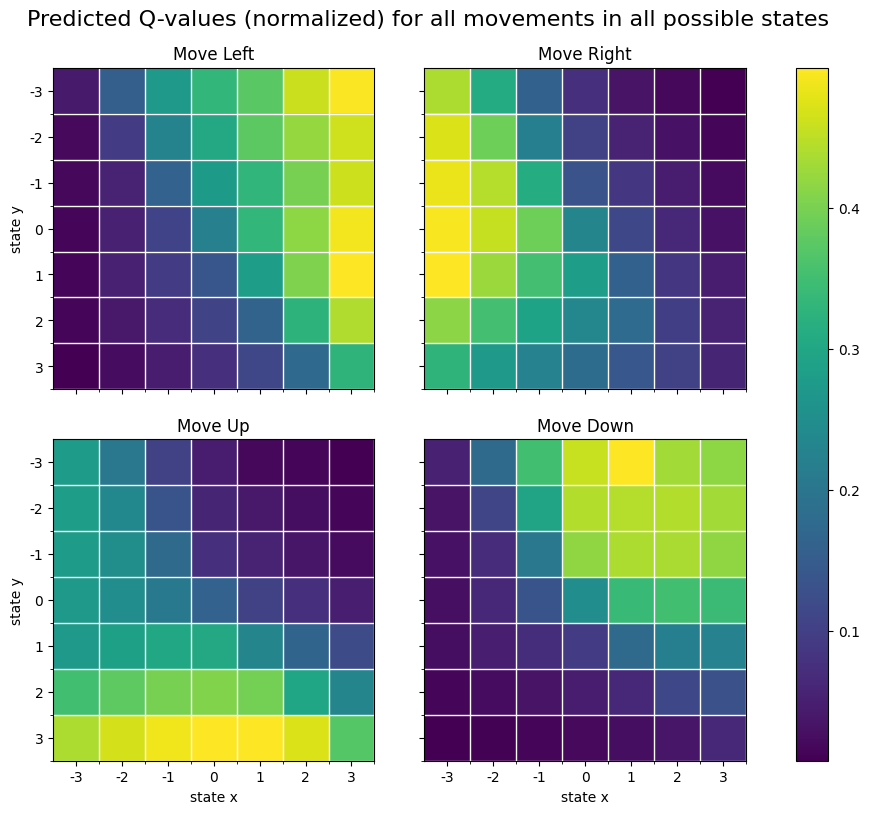

In [7]:
Visualization.plot_move_qvals_per_state(network, env)

- **Policy Visualization**

To visualize the policy, for a particular episode, we plot only the direction (action) with the highest q-value, $Q(s, a)$, learnt by the model so far, given the state. With this we can get a comprehensive overview of the best actions for each possible state. 

Note that due to the changing locations of point A and B, the policy would vary for different configurations.

Regardless as you can see from the plots below, for every grid cell, the best suggested action will always bring the agent closer to the target, for both location A and B (Note that B only becomes a target after A is reached) showing not only that our model has clearly learnt the task very well but also that it has sufficiently explored all the states.

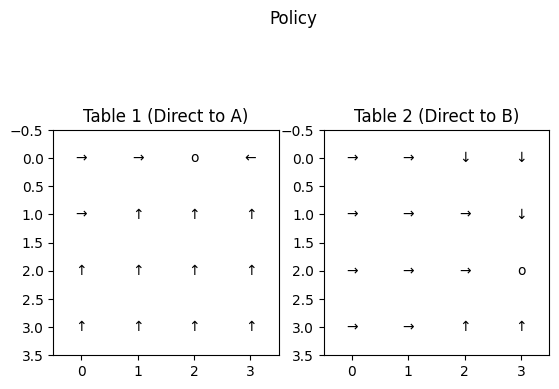

In [8]:
Visualization.plot_policy(env, learning, history)

- **Path Visualization**

To visualize the learning progress, we plot the path taken by the agent in a random run in the first evaluation episode and then a random run from the last episode. 

As you can see in the first episode, the agent will most likely get stuck moving back and forth over a small area, this is because during evaluation our target policy completely exploits the learnt Q table. Since in the first episode, it hasn't learnt much of anything getting stuck is to be expected.

However in the final episode, the agent performs impressively by executing the shortest path to first pick up A then go to B! This concretely shows the progress that has been made between the first and last evaluation episodes.

The plot is designed using interactive HTML environment so that it can animate the actions made by the agent sequentially to trace the path taken by the agent. 

Controls:
- Press the `>` button to move the animation forward
- Press `<` to reverse the animation
- Press the `+` button to speed up animation
- Press the `-` button to slow down animation

*Note: you can re-run the code block below to get a different random first and last evaluation episode*

*Note: since the agent path animation chooses a random evaluation configuration from the last episode it may not be the same one as the policy plot*

In [9]:
Visualization.plot_first_and_last_path_eval(eval_history)

- **SmoothL1Loss Graph**

Below shows the loss graph for the SmoothL1Loss used to train the deep-q network.

*NOTE: THIS GRAPH IS DIFFERENT FROM THE CUSTOM METRICS (L1, L2 Losses) WE DESIGNED AND IS NOT A GOOD INDICATOR OF HOW WELL THE AGENT PERFORMS THE TASK*

This loss simply shows the average difference between the predicted Q-value from the prediction network and the reward + predicted Q-value from the target network. Since both networks are learning throughout training, this graph is a better indicator of convergence. As you can see the spikes in losses are quite drastic in the beginning due to very different projections between target and prediction network, however at the end you can see that the fluctuations are much tamer showing that the prediction and target network's outputs are very close.

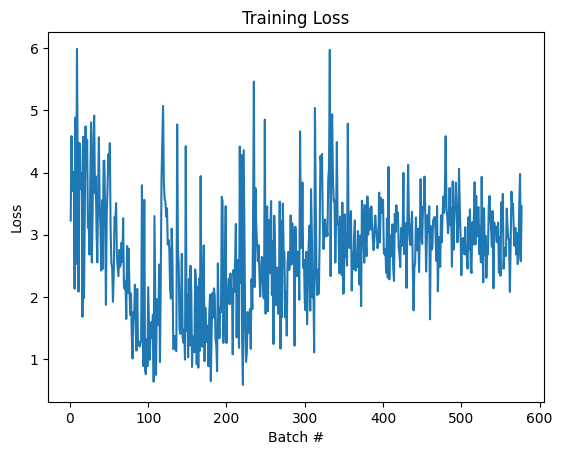

In [10]:
Visualization.plot_training_loss(engine)

- **State & Q-Values Visualization**

To find how important a state is, we will show the summation of Q-Values of the action from adjacent states that lead to the state.  
  
From the plots below, we can see that the peak is at (0,0), this is the location of the target and coming quite close at second place is at (1,1) which is very close to (0,0). Importantly you can see that no matter what state you begin in, there is always a neighboring state with a higher reward which moves you towards the center (0,0).

This shows that our Deep Q-Learning is successful.


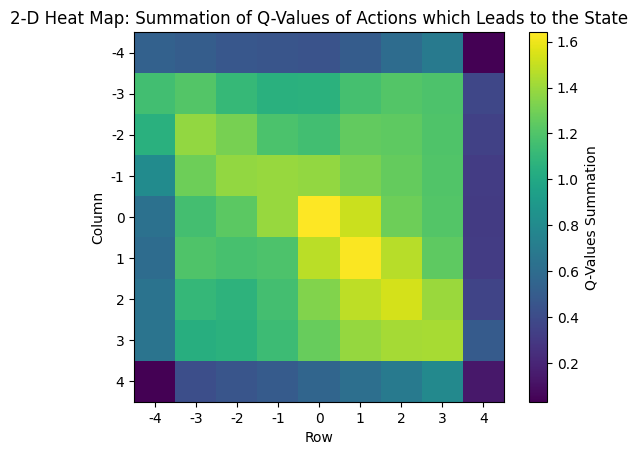

In [12]:
Visualization.plot_q_values_2d(learning)

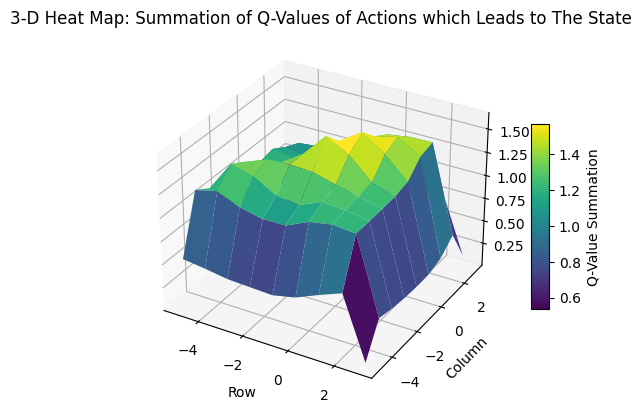

In [13]:
Visualization.plot_q_values_3d(learning)

## Dueling

In order to improve the instability and low convergeance problems in DQN, various techniques have been applied. Among them, we have chosen to experiment with Dueling DQN architecture.

The idea of dueling network is intuitive such that it is not necessary to estimate the value of each action choice. Building on top of the concept, another stream (branch) is added to DQN for estimating the advantage function value which later combined with the value estimation by another stream to obtain the final Q-value.

The idea could be expressed mathematically as follows.

\begin{equation*}
    Q^{\pi}(s) = V^{\pi}(s) + A^{\pi}(s)
\end{equation*}

where $V^{\pi}(s)$ is the state-value function of $s$ and $A^{\pi}(s)$ is the advantage function of $s$ which measure the relative importance of each action. Since

\begin{equation*}
    V^{\pi}(s) = \mathbb{E}_{a\sim \pi(s)}[Q^{\pi}(s,a)]
\end{equation*}

It follows that $\mathbb{E}_{a\sim \pi(s)}[A^{\pi}(s,a)] = 0$. For a deterministic policy, $a^* = \arg\max_{a'\in A}Q(s, a')$, it follows that $Q(s,a^*) = V(s)$ with $A(s, a^*) = 0$.

However, follow the above equation would produce an unidentifiable result such that given $Q$, we cannot recover $V$ and $A$ uniquely. To see why, adding a constant $c$ to $V$ and $-c$ to $A$ would result in the same $Q$ value. This lack of identifiability is poor. To address this issue, the advantage function of chosen action is forced to be 0, resulting in the following equation.

\begin{equation*}
    Q(s, a; \theta, \alpha, \beta) = V(s; \theta, \beta) + (A(s, a;\theta,\alpha) - \max_{a'\in |A|} A(s, a';\theta,\alpha))
\end{equation*}

With the above equation, we have $V(s;\theta,\beta)$ provides an estimate of the value function while $A(s, a';\theta,\alpha)$ provides an estimate of the advantage function. However, the update is yet a stable estimator and hence is replaced by the following equation for stable training.

\begin{equation*}
    Q(s, a; \theta,\alpha,\beta) = V(s;\theta,\beta) + (A(s, a;\theta,\alpha) - \frac{1}{|A|}\sum_a'A(s, a';\theta, \alpha))
\end{equation*}

Note subtracting mean in the above equation helps with identifiability and also preserves any greedy or $\epsilon$-greedy policy based on Q values from original equation. Overall, the update is similar with DQN with an extra weights to be updated for double-streams architecture. 

For implementation purpose, please refer to the following relevant class.
- `Dueling` (A class for implementing the Dueling architecture design) located [**here**](modules/model.py)

In [14]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [15]:
history_d = History()
eval_history_d = History()
env_d = Environment((4,4), history_d)
agent_d = Agent(env_d)
reward_d = Reward(env_d, agent_d)

In [16]:
model_d = Dueling(2)
network_d = QNetwork(model_d, 0)
optimizer_d = optim.Adam(model_d.parameters(), lr=0.01)
criterion_d = nn.SmoothL1Loss()
learning_d = DeepQLearning(network_d, optimizer_d, criterion_d, update_interval=200)

In [17]:
engine = Engine(env_d, reward_d, agent_d, learning_d, history_d,
                eval_history_d, losses=[L1_Loss, L2_Loss], 
                iters=2000, eval_interval=100)
engine.run()

=====EVALUATION AT EPISODE 100: REWARD=-10170.008=====
====EVALUATION AT EPISODE 100: LOSS=L1_Loss, VALUE=(83.82, 99.2)=====
====EVALUATION AT EPISODE 100: LOSS=L2_Loss, VALUE=(8380.04, 9920.0)=====
=====EVALUATION AT EPISODE 200: REWARD=-9614.952=====
====EVALUATION AT EPISODE 200: LOSS=L1_Loss, VALUE=(72.4, 93.8)=====
====EVALUATION AT EPISODE 200: LOSS=L2_Loss, VALUE=(7240.0, 9380.0)=====
=====EVALUATION AT EPISODE 300: REWARD=-7843.134=====
====EVALUATION AT EPISODE 300: LOSS=L1_Loss, VALUE=(51.848, 76.704)=====
====EVALUATION AT EPISODE 300: LOSS=L2_Loss, VALUE=(5160.496, 7660.208)=====
=====EVALUATION AT EPISODE 400: REWARD=-3877.608=====
====EVALUATION AT EPISODE 400: LOSS=L1_Loss, VALUE=(19.0, 38.0)=====
====EVALUATION AT EPISODE 400: LOSS=L2_Loss, VALUE=(1900.0, 3800.0)=====
=====EVALUATION AT EPISODE 500: REWARD=-4598.242=====
====EVALUATION AT EPISODE 500: LOSS=L1_Loss, VALUE=(23.456, 45.04)=====
====EVALUATION AT EPISODE 500: LOSS=L2_Loss, VALUE=(2340.112, 4500.08)=====
===

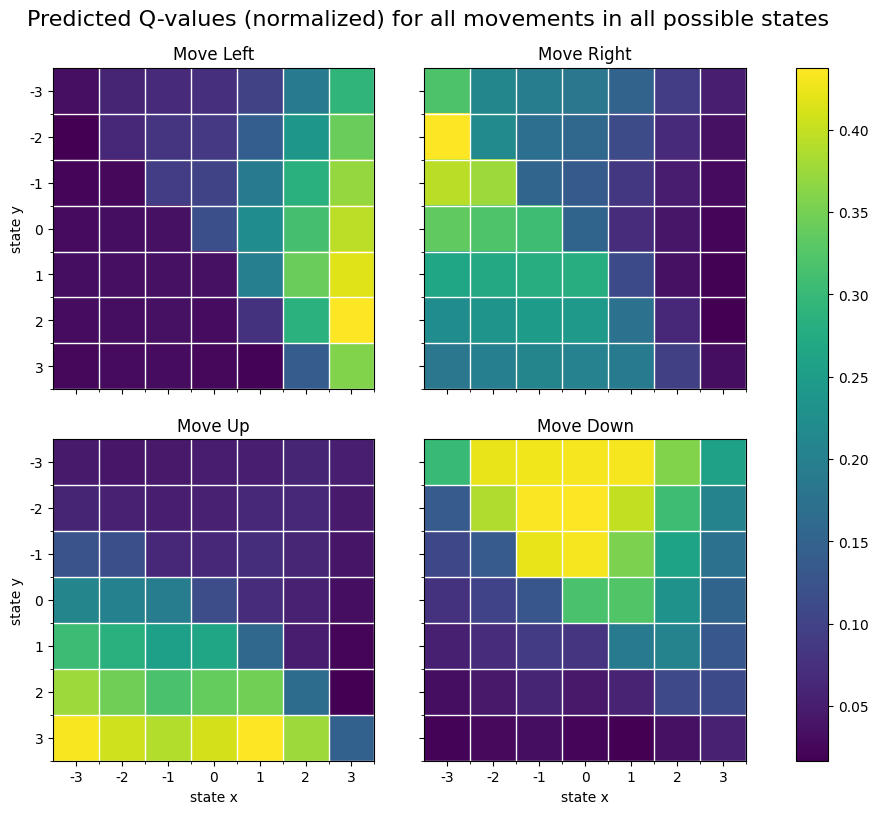

In [18]:
Visualization.plot_move_qvals_per_state(network_d, env_d)

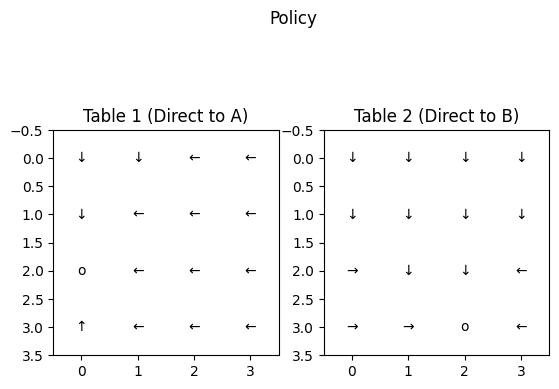

In [19]:
Visualization.plot_policy(env_d, learning_d, history_d)

In [20]:
Visualization.plot_first_and_last_path_eval(eval_history_d)

- **Loss Graphs (Training)**

To visualize the performance of our model over time, we plot the losses over the number of episodes as a line graph. 
Note: these are the custom L1 and L2 losses (NOT the SmoothL1Loss used for training the Deep Q-Network) which directly assesses model performance in reaching the target via the least number of steps

Note: the spikes in losses are due to the moving goalpost when weights of prediction network is copied over to target network, importantly you can see that the spikes in losses decrease as training progresses and eventually loss converges to 0, which proves that our model is learning

We note that although the original Deep-Q method had higher average losses in earlier batches, after its loss decreased to 0, regardless of moving goalpost, no more loss spikes were seen showing that it converged stably. On the other hand, Dueling method had lower average losses in the beginning but experienced larger spikes later on showing instability for this particular hyperparameter configuration.

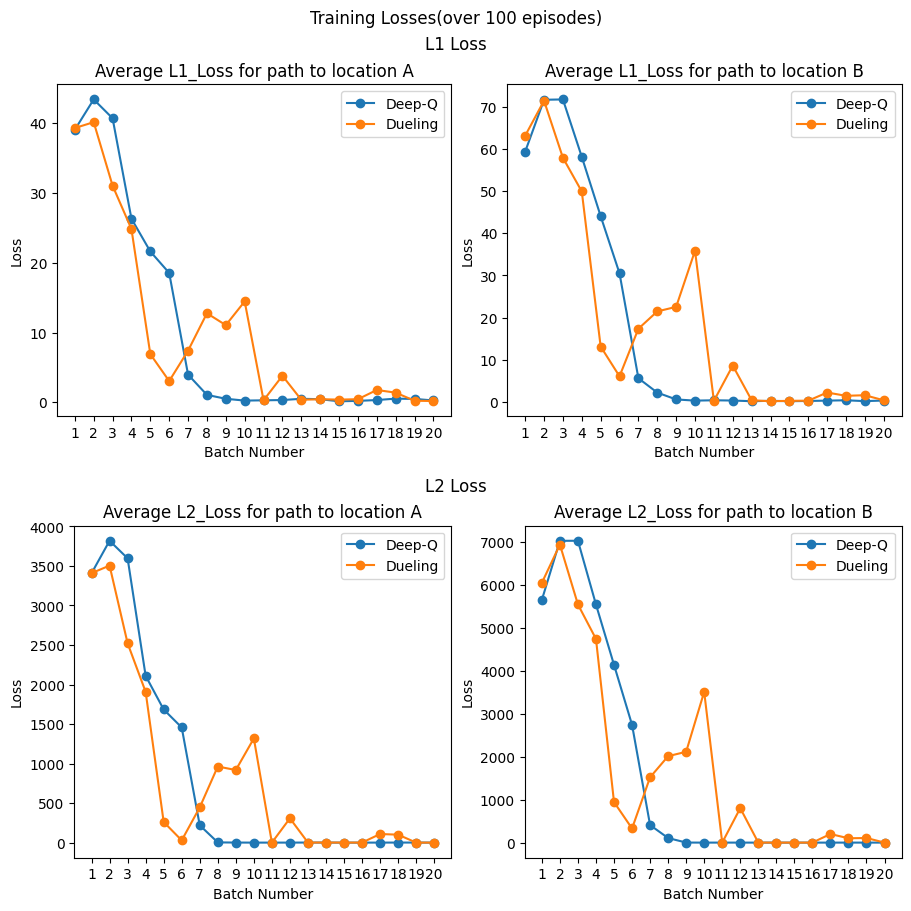

In [21]:
model_histories = {
    "Deep-Q": history,
    "Dueling": history_d
}

Visualization.plot_losses(model_histories)

- **Loss Graphs (Evaluation)**

On the other hand, looking at the evaluation losses we can see that they are generally decreasing, though there are spikes in the losses as to be expected due to copying the weights over between the target and prediction network (moving goal post), eventually losses reach 0, unlike during training, we fully exploit and do not explore, thus it is a more accurate indicator of how well our Q values have updated and the quick decline in losses strongly indicates that the model is steadily and quickly learning. 

Furthermore it converges fast and reaches a loss of 0 meaning that for possible (agent, location A, location B) configurations, the agent *always* takes the ideal path.

Similar to the trend we saw for training loss graphs, here the original Deep-Q network's losses converge faster and does not spike afterwards showing stability meanwhile for Dueling method, the loss spikes around episode 800 showing instability.

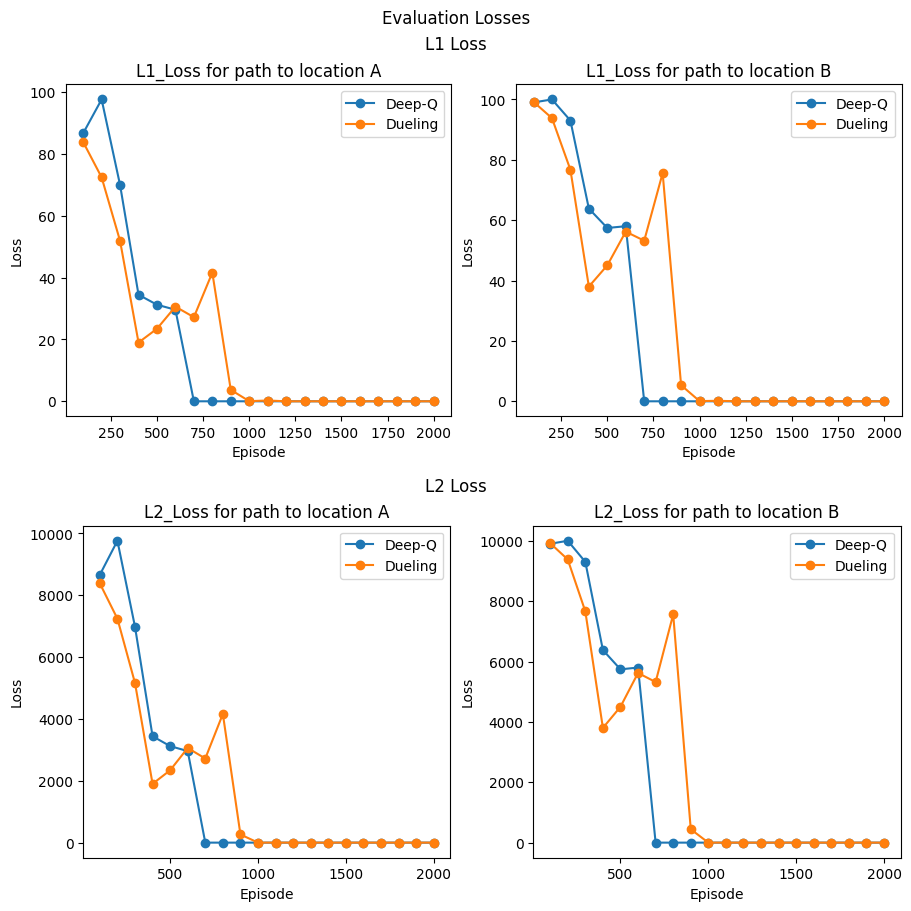

In [22]:
model_histories = {
    "Deep-Q": eval_history,
    "Dueling": eval_history_d
}

Visualization.plot_losses(model_histories, train=False)

---

# Scalability and Generalizability Testing

## Hyper-parameter Testing

Here we perform hyper-parameter testing to show that our solution is adaptive to many different parameter values.
In particular, here we train and evaluate a model for every combination of the following sets of hyperparameters:
- learning_rates = [0.1, 0.01, 0.001]
- gammas = [0.1, 0.9]
- taus = [0, 0.5, 0.9]
- doubles = [True, False]

After training and testing all these models, the top 5 models (determined by minimum average evaluation loss as well as speed to convergence) are plotted below.

*Please note that running the following code cell will take upwards of 1 hour depending on your computing power.*

For more details, please refer to the implementation:
- `hyperparam_search` (function to perform hyperparameter testing which will train and evaluate each model) located [**here**](modules/search.py)

In [23]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [24]:
hyperparam_search(save_to="hyperparam_search_res.pkl")

testing with lr: 0.1, gamma: 0.1, tau: 0, double: True
=====EVALUATION AT EPISODE 100: REWARD=-10097.862=====
====EVALUATION AT EPISODE 100: LOSS=L1_Loss, VALUE=(74.4, 95.4)=====
====EVALUATION AT EPISODE 100: LOSS=L2_Loss, VALUE=(7440.0, 9540.0)=====
=====EVALUATION AT EPISODE 200: REWARD=-10409.606=====
====EVALUATION AT EPISODE 200: LOSS=L1_Loss, VALUE=(78.68, 98.404)=====
====EVALUATION AT EPISODE 200: LOSS=L2_Loss, VALUE=(7860.16, 9840.008)=====
=====EVALUATION AT EPISODE 300: REWARD=-10550.866=====
====EVALUATION AT EPISODE 300: LOSS=L1_Loss, VALUE=(90.2, 99.2)=====
====EVALUATION AT EPISODE 300: LOSS=L2_Loss, VALUE=(9020.0, 9920.0)=====
=====EVALUATION AT EPISODE 400: REWARD=-10253.824=====
====EVALUATION AT EPISODE 400: LOSS=L1_Loss, VALUE=(81.0, 96.8)=====
====EVALUATION AT EPISODE 400: LOSS=L2_Loss, VALUE=(8100.0, 9680.0)=====
=====EVALUATION AT EPISODE 500: REWARD=-10535.124=====
====EVALUATION AT EPISODE 500: LOSS=L1_Loss, VALUE=(88.4, 99.0)=====
====EVALUATION AT EPISODE 5

=====EVALUATION AT EPISODE 200: REWARD=-10374.024=====
====EVALUATION AT EPISODE 200: LOSS=L1_Loss, VALUE=(78.136, 97.82)=====
====EVALUATION AT EPISODE 200: LOSS=L2_Loss, VALUE=(7800.272, 9780.04)=====
=====EVALUATION AT EPISODE 300: REWARD=-10235.536=====
====EVALUATION AT EPISODE 300: LOSS=L1_Loss, VALUE=(78.436, 96.808)=====
====EVALUATION AT EPISODE 300: LOSS=L2_Loss, VALUE=(7840.072, 9680.016)=====
=====EVALUATION AT EPISODE 400: REWARD=-10364.238=====
====EVALUATION AT EPISODE 400: LOSS=L1_Loss, VALUE=(79.244, 98.0)=====
====EVALUATION AT EPISODE 400: LOSS=L2_Loss, VALUE=(7920.088, 9800.0)=====
=====EVALUATION AT EPISODE 500: REWARD=-10557.162=====
====EVALUATION AT EPISODE 500: LOSS=L1_Loss, VALUE=(90.6, 99.2)=====
====EVALUATION AT EPISODE 500: LOSS=L2_Loss, VALUE=(9060.0, 9920.0)=====
=====EVALUATION AT EPISODE 600: REWARD=-10578.614=====
====EVALUATION AT EPISODE 600: LOSS=L1_Loss, VALUE=(89.2, 99.4)=====
====EVALUATION AT EPISODE 600: LOSS=L2_Loss, VALUE=(8920.0, 9940.0)===

=====EVALUATION AT EPISODE 300: REWARD=-10369.64=====
====EVALUATION AT EPISODE 300: LOSS=L1_Loss, VALUE=(80.84, 98.0)=====
====EVALUATION AT EPISODE 300: LOSS=L2_Loss, VALUE=(8080.08, 9800.0)=====
=====EVALUATION AT EPISODE 400: REWARD=-10600.292=====
====EVALUATION AT EPISODE 400: LOSS=L1_Loss, VALUE=(92.6, 99.6)=====
====EVALUATION AT EPISODE 400: LOSS=L2_Loss, VALUE=(9260.0, 9960.0)=====
=====EVALUATION AT EPISODE 500: REWARD=-10575.552=====
====EVALUATION AT EPISODE 500: LOSS=L1_Loss, VALUE=(89.8, 99.4)=====
====EVALUATION AT EPISODE 500: LOSS=L2_Loss, VALUE=(8980.0, 9940.0)=====
=====EVALUATION AT EPISODE 600: REWARD=-10593.76=====
====EVALUATION AT EPISODE 600: LOSS=L1_Loss, VALUE=(92.0, 99.6)=====
====EVALUATION AT EPISODE 600: LOSS=L2_Loss, VALUE=(9200.0, 9960.0)=====
=====EVALUATION AT EPISODE 700: REWARD=-10463.214=====
====EVALUATION AT EPISODE 700: LOSS=L1_Loss, VALUE=(83.4, 98.8)=====
====EVALUATION AT EPISODE 700: LOSS=L2_Loss, VALUE=(8340.0, 9880.0)=====
=====EVALUATION

=====EVALUATION AT EPISODE 400: REWARD=-10579.812=====
====EVALUATION AT EPISODE 400: LOSS=L1_Loss, VALUE=(91.4, 99.4)=====
====EVALUATION AT EPISODE 400: LOSS=L2_Loss, VALUE=(9140.0, 9940.0)=====
=====EVALUATION AT EPISODE 500: REWARD=-10424.342=====
====EVALUATION AT EPISODE 500: LOSS=L1_Loss, VALUE=(83.8, 98.4)=====
====EVALUATION AT EPISODE 500: LOSS=L2_Loss, VALUE=(8380.0, 9840.0)=====
=====EVALUATION AT EPISODE 600: REWARD=-10218.092=====
====EVALUATION AT EPISODE 600: LOSS=L1_Loss, VALUE=(80.26, 96.616)=====
====EVALUATION AT EPISODE 600: LOSS=L2_Loss, VALUE=(8020.12, 9660.032)=====
=====EVALUATION AT EPISODE 700: REWARD=-10619.878=====
====EVALUATION AT EPISODE 700: LOSS=L1_Loss, VALUE=(90.0, 99.8)=====
====EVALUATION AT EPISODE 700: LOSS=L2_Loss, VALUE=(9000.0, 9980.0)=====
=====EVALUATION AT EPISODE 800: REWARD=-10526.662=====
====EVALUATION AT EPISODE 800: LOSS=L1_Loss, VALUE=(84.2, 99.4)=====
====EVALUATION AT EPISODE 800: LOSS=L2_Loss, VALUE=(8420.0, 9940.0)=====
=====EVAL

=====EVALUATION AT EPISODE 500: REWARD=-10363.66=====
====EVALUATION AT EPISODE 500: LOSS=L1_Loss, VALUE=(79.076, 98.0)=====
====EVALUATION AT EPISODE 500: LOSS=L2_Loss, VALUE=(7900.152, 9800.0)=====
=====EVALUATION AT EPISODE 600: REWARD=-10555.222=====
====EVALUATION AT EPISODE 600: LOSS=L1_Loss, VALUE=(91.6, 99.2)=====
====EVALUATION AT EPISODE 600: LOSS=L2_Loss, VALUE=(9160.0, 9920.0)=====
=====EVALUATION AT EPISODE 700: REWARD=-10382.3=====
====EVALUATION AT EPISODE 700: LOSS=L1_Loss, VALUE=(82.8, 98.0)=====
====EVALUATION AT EPISODE 700: LOSS=L2_Loss, VALUE=(8280.0, 9800.0)=====
=====EVALUATION AT EPISODE 800: REWARD=-10598.738=====
====EVALUATION AT EPISODE 800: LOSS=L1_Loss, VALUE=(91.6, 99.6)=====
====EVALUATION AT EPISODE 800: LOSS=L2_Loss, VALUE=(9160.0, 9960.0)=====
=====EVALUATION AT EPISODE 900: REWARD=-10321.75=====
====EVALUATION AT EPISODE 900: LOSS=L1_Loss, VALUE=(78.456, 97.6)=====
====EVALUATION AT EPISODE 900: LOSS=L2_Loss, VALUE=(7840.112, 9760.0)=====
=====EVALUA

=====EVALUATION AT EPISODE 600: REWARD=-10619.838=====
====EVALUATION AT EPISODE 600: LOSS=L1_Loss, VALUE=(89.6, 99.8)=====
====EVALUATION AT EPISODE 600: LOSS=L2_Loss, VALUE=(8960.0, 9980.0)=====
=====EVALUATION AT EPISODE 700: REWARD=-10238.744=====
====EVALUATION AT EPISODE 700: LOSS=L1_Loss, VALUE=(80.476, 96.8)=====
====EVALUATION AT EPISODE 700: LOSS=L2_Loss, VALUE=(8040.152, 9680.0)=====
=====EVALUATION AT EPISODE 800: REWARD=-10554.708=====
====EVALUATION AT EPISODE 800: LOSS=L1_Loss, VALUE=(92.8, 99.2)=====
====EVALUATION AT EPISODE 800: LOSS=L2_Loss, VALUE=(9280.0, 9920.0)=====
=====EVALUATION AT EPISODE 900: REWARD=-10306.64=====
====EVALUATION AT EPISODE 900: LOSS=L1_Loss, VALUE=(82.256, 97.404)=====
====EVALUATION AT EPISODE 900: LOSS=L2_Loss, VALUE=(8220.112, 9740.008)=====
=====EVALUATION AT EPISODE 1000: REWARD=-10619.658=====
====EVALUATION AT EPISODE 1000: LOSS=L1_Loss, VALUE=(90.0, 99.8)=====
====EVALUATION AT EPISODE 1000: LOSS=L2_Loss, VALUE=(9000.0, 9980.0)=====
=

=====EVALUATION AT EPISODE 700: REWARD=14.018=====
====EVALUATION AT EPISODE 700: LOSS=L1_Loss, VALUE=(0.664, 0.548)=====
====EVALUATION AT EPISODE 700: LOSS=L2_Loss, VALUE=(2.112, 1.656)=====
=====EVALUATION AT EPISODE 800: REWARD=14.194=====
====EVALUATION AT EPISODE 800: LOSS=L1_Loss, VALUE=(0.604, 0.452)=====
====EVALUATION AT EPISODE 800: LOSS=L2_Loss, VALUE=(1.96, 1.496)=====
=====EVALUATION AT EPISODE 900: REWARD=14.51=====
====EVALUATION AT EPISODE 900: LOSS=L1_Loss, VALUE=(0.488, 0.412)=====
====EVALUATION AT EPISODE 900: LOSS=L2_Loss, VALUE=(1.376, 1.112)=====
=====EVALUATION AT EPISODE 1000: REWARD=14.382=====
====EVALUATION AT EPISODE 1000: LOSS=L1_Loss, VALUE=(0.444, 0.364)=====
====EVALUATION AT EPISODE 1000: LOSS=L2_Loss, VALUE=(1.16, 1.0)=====
=====EVALUATION AT EPISODE 1100: REWARD=14.734=====
====EVALUATION AT EPISODE 1100: LOSS=L1_Loss, VALUE=(0.276, 0.364)=====
====EVALUATION AT EPISODE 1100: LOSS=L2_Loss, VALUE=(0.856, 1.08)=====
=====EVALUATION AT EPISODE 1200: RE

=====EVALUATION AT EPISODE 900: REWARD=-1067.388=====
====EVALUATION AT EPISODE 900: LOSS=L1_Loss, VALUE=(4.2, 10.2)=====
====EVALUATION AT EPISODE 900: LOSS=L2_Loss, VALUE=(420.0, 1020.0)=====
=====EVALUATION AT EPISODE 1000: REWARD=15.392=====
====EVALUATION AT EPISODE 1000: LOSS=L1_Loss, VALUE=(0.0, 0.0)=====
====EVALUATION AT EPISODE 1000: LOSS=L2_Loss, VALUE=(0.0, 0.0)=====
=====EVALUATION AT EPISODE 1100: REWARD=-154.708=====
====EVALUATION AT EPISODE 1100: LOSS=L1_Loss, VALUE=(1.0, 1.6)=====
====EVALUATION AT EPISODE 1100: LOSS=L2_Loss, VALUE=(100.0, 160.0)=====
=====EVALUATION AT EPISODE 1200: REWARD=-748.49=====
====EVALUATION AT EPISODE 1200: LOSS=L1_Loss, VALUE=(2.8, 7.2)=====
====EVALUATION AT EPISODE 1200: LOSS=L2_Loss, VALUE=(280.0, 720.0)=====
=====EVALUATION AT EPISODE 1300: REWARD=-2844.35=====
====EVALUATION AT EPISODE 1300: LOSS=L1_Loss, VALUE=(12.6, 27.0)=====
====EVALUATION AT EPISODE 1300: LOSS=L2_Loss, VALUE=(1260.0, 2700.0)=====
=====EVALUATION AT EPISODE 1400: 

=====EVALUATION AT EPISODE 1100: REWARD=15.456=====
====EVALUATION AT EPISODE 1100: LOSS=L1_Loss, VALUE=(0.0, 0.0)=====
====EVALUATION AT EPISODE 1100: LOSS=L2_Loss, VALUE=(0.0, 0.0)=====
=====EVALUATION AT EPISODE 1200: REWARD=15.328=====
====EVALUATION AT EPISODE 1200: LOSS=L1_Loss, VALUE=(0.0, 0.0)=====
====EVALUATION AT EPISODE 1200: LOSS=L2_Loss, VALUE=(0.0, 0.0)=====
=====EVALUATION AT EPISODE 1300: REWARD=15.36=====
====EVALUATION AT EPISODE 1300: LOSS=L1_Loss, VALUE=(0.024, 0.04)=====
====EVALUATION AT EPISODE 1300: LOSS=L2_Loss, VALUE=(0.048, 0.08)=====
=====EVALUATION AT EPISODE 1400: REWARD=15.454=====
====EVALUATION AT EPISODE 1400: LOSS=L1_Loss, VALUE=(0.008, 0.012)=====
====EVALUATION AT EPISODE 1400: LOSS=L2_Loss, VALUE=(0.016, 0.024)=====
=====EVALUATION AT EPISODE 1500: REWARD=15.152=====
====EVALUATION AT EPISODE 1500: LOSS=L1_Loss, VALUE=(0.04, 0.028)=====
====EVALUATION AT EPISODE 1500: LOSS=L2_Loss, VALUE=(0.08, 0.056)=====
=====EVALUATION AT EPISODE 1600: REWARD=1

=====EVALUATION AT EPISODE 1300: REWARD=14.948=====
====EVALUATION AT EPISODE 1300: LOSS=L1_Loss, VALUE=(0.184, 0.116)=====
====EVALUATION AT EPISODE 1300: LOSS=L2_Loss, VALUE=(0.784, 0.376)=====
=====EVALUATION AT EPISODE 1400: REWARD=14.926=====
====EVALUATION AT EPISODE 1400: LOSS=L1_Loss, VALUE=(0.228, 0.304)=====
====EVALUATION AT EPISODE 1400: LOSS=L2_Loss, VALUE=(1.016, 1.408)=====
=====EVALUATION AT EPISODE 1500: REWARD=14.874=====
====EVALUATION AT EPISODE 1500: LOSS=L1_Loss, VALUE=(0.208, 0.352)=====
====EVALUATION AT EPISODE 1500: LOSS=L2_Loss, VALUE=(0.88, 1.584)=====
=====EVALUATION AT EPISODE 1600: REWARD=14.762=====
====EVALUATION AT EPISODE 1600: LOSS=L1_Loss, VALUE=(0.316, 0.368)=====
====EVALUATION AT EPISODE 1600: LOSS=L2_Loss, VALUE=(1.352, 1.664)=====
=====EVALUATION AT EPISODE 1700: REWARD=14.622=====
====EVALUATION AT EPISODE 1700: LOSS=L1_Loss, VALUE=(0.264, 0.352)=====
====EVALUATION AT EPISODE 1700: LOSS=L2_Loss, VALUE=(1.152, 1.472)=====
=====EVALUATION AT EP

=====EVALUATION AT EPISODE 1500: REWARD=-10224.834=====
====EVALUATION AT EPISODE 1500: LOSS=L1_Loss, VALUE=(79.048, 96.804)=====
====EVALUATION AT EPISODE 1500: LOSS=L2_Loss, VALUE=(7900.096, 9680.008)=====
=====EVALUATION AT EPISODE 1600: REWARD=-9553.83=====
====EVALUATION AT EPISODE 1600: LOSS=L1_Loss, VALUE=(59.0, 90.2)=====
====EVALUATION AT EPISODE 1600: LOSS=L2_Loss, VALUE=(5900.0, 9020.0)=====
=====EVALUATION AT EPISODE 1700: REWARD=-10384.216=====
====EVALUATION AT EPISODE 1700: LOSS=L1_Loss, VALUE=(80.464, 98.0)=====
====EVALUATION AT EPISODE 1700: LOSS=L2_Loss, VALUE=(8040.128, 9800.0)=====
=====EVALUATION AT EPISODE 1800: REWARD=-10442.5=====
====EVALUATION AT EPISODE 1800: LOSS=L1_Loss, VALUE=(82.2, 98.2)=====
====EVALUATION AT EPISODE 1800: LOSS=L2_Loss, VALUE=(8220.0, 9820.0)=====
=====EVALUATION AT EPISODE 1900: REWARD=-10440.402=====
====EVALUATION AT EPISODE 1900: LOSS=L1_Loss, VALUE=(83.4, 98.4)=====
====EVALUATION AT EPISODE 1900: LOSS=L2_Loss, VALUE=(8340.0, 9840.

=====EVALUATION AT EPISODE 1700: REWARD=15.218=====
====EVALUATION AT EPISODE 1700: LOSS=L1_Loss, VALUE=(0.0, 0.0)=====
====EVALUATION AT EPISODE 1700: LOSS=L2_Loss, VALUE=(0.0, 0.0)=====
=====EVALUATION AT EPISODE 1800: REWARD=15.452=====
====EVALUATION AT EPISODE 1800: LOSS=L1_Loss, VALUE=(0.0, 0.0)=====
====EVALUATION AT EPISODE 1800: LOSS=L2_Loss, VALUE=(0.0, 0.0)=====
=====EVALUATION AT EPISODE 1900: REWARD=15.108=====
====EVALUATION AT EPISODE 1900: LOSS=L1_Loss, VALUE=(0.052, 0.08)=====
====EVALUATION AT EPISODE 1900: LOSS=L2_Loss, VALUE=(0.104, 0.16)=====
=====EVALUATION AT EPISODE 2000: REWARD=15.304=====
====EVALUATION AT EPISODE 2000: LOSS=L1_Loss, VALUE=(0.04, 0.036)=====
====EVALUATION AT EPISODE 2000: LOSS=L2_Loss, VALUE=(0.08, 0.072)=====
testing with lr: 0.01, gamma: 0.9, tau: 0.9, double: False
=====EVALUATION AT EPISODE 100: REWARD=-10656.29=====
====EVALUATION AT EPISODE 100: LOSS=L1_Loss, VALUE=(97.8, 100.0)=====
====EVALUATION AT EPISODE 100: LOSS=L2_Loss, VALUE=(9

=====EVALUATION AT EPISODE 1800: REWARD=-452.528=====
====EVALUATION AT EPISODE 1800: LOSS=L1_Loss, VALUE=(2.272, 4.788)=====
====EVALUATION AT EPISODE 1800: LOSS=L2_Loss, VALUE=(200.544, 440.776)=====
=====EVALUATION AT EPISODE 1900: REWARD=15.118=====
====EVALUATION AT EPISODE 1900: LOSS=L1_Loss, VALUE=(0.056, 0.02)=====
====EVALUATION AT EPISODE 1900: LOSS=L2_Loss, VALUE=(0.112, 0.04)=====
=====EVALUATION AT EPISODE 2000: REWARD=15.284=====
====EVALUATION AT EPISODE 2000: LOSS=L1_Loss, VALUE=(0.0, 0.0)=====
====EVALUATION AT EPISODE 2000: LOSS=L2_Loss, VALUE=(0.0, 0.0)=====
testing with lr: 0.001, gamma: 0.1, tau: 0, double: False
=====EVALUATION AT EPISODE 100: REWARD=-10358.47=====
====EVALUATION AT EPISODE 100: LOSS=L1_Loss, VALUE=(79.624, 98.004)=====
====EVALUATION AT EPISODE 100: LOSS=L2_Loss, VALUE=(7960.048, 9800.008)=====
=====EVALUATION AT EPISODE 200: REWARD=-10481.104=====
====EVALUATION AT EPISODE 200: LOSS=L1_Loss, VALUE=(87.456, 99.0)=====
====EVALUATION AT EPISODE 20

=====EVALUATION AT EPISODE 1900: REWARD=14.82=====
====EVALUATION AT EPISODE 1900: LOSS=L1_Loss, VALUE=(0.284, 0.352)=====
====EVALUATION AT EPISODE 1900: LOSS=L2_Loss, VALUE=(0.568, 0.704)=====
=====EVALUATION AT EPISODE 2000: REWARD=14.626=====
====EVALUATION AT EPISODE 2000: LOSS=L1_Loss, VALUE=(0.352, 0.316)=====
====EVALUATION AT EPISODE 2000: LOSS=L2_Loss, VALUE=(0.704, 0.632)=====
testing with lr: 0.001, gamma: 0.1, tau: 0.5, double: False
=====EVALUATION AT EPISODE 100: REWARD=-10613.554=====
====EVALUATION AT EPISODE 100: LOSS=L1_Loss, VALUE=(99.6, 100.0)=====
====EVALUATION AT EPISODE 100: LOSS=L2_Loss, VALUE=(9960.0, 10000.0)=====
=====EVALUATION AT EPISODE 200: REWARD=-10611.62=====
====EVALUATION AT EPISODE 200: LOSS=L1_Loss, VALUE=(99.6, 100.0)=====
====EVALUATION AT EPISODE 200: LOSS=L2_Loss, VALUE=(9960.0, 10000.0)=====
=====EVALUATION AT EPISODE 300: REWARD=-10611.96=====
====EVALUATION AT EPISODE 300: LOSS=L1_Loss, VALUE=(99.4, 100.0)=====
====EVALUATION AT EPISODE 30

=====EVALUATION AT EPISODE 2000: REWARD=-10475.716=====
====EVALUATION AT EPISODE 2000: LOSS=L1_Loss, VALUE=(80.0, 98.6)=====
====EVALUATION AT EPISODE 2000: LOSS=L2_Loss, VALUE=(8000.0, 9860.0)=====
testing with lr: 0.001, gamma: 0.1, tau: 0.9, double: False
=====EVALUATION AT EPISODE 100: REWARD=-9966.416=====
====EVALUATION AT EPISODE 100: LOSS=L1_Loss, VALUE=(72.248, 94.204)=====
====EVALUATION AT EPISODE 100: LOSS=L2_Loss, VALUE=(7220.096, 9420.008)=====
=====EVALUATION AT EPISODE 200: REWARD=-9946.674=====
====EVALUATION AT EPISODE 200: LOSS=L1_Loss, VALUE=(72.472, 94.004)=====
====EVALUATION AT EPISODE 200: LOSS=L2_Loss, VALUE=(7240.144, 9400.008)=====
=====EVALUATION AT EPISODE 300: REWARD=-10007.006=====
====EVALUATION AT EPISODE 300: LOSS=L1_Loss, VALUE=(70.468, 94.612)=====
====EVALUATION AT EPISODE 300: LOSS=L2_Loss, VALUE=(7040.136, 9460.024)=====
=====EVALUATION AT EPISODE 400: REWARD=-10290.32=====
====EVALUATION AT EPISODE 400: LOSS=L1_Loss, VALUE=(79.468, 97.2)=====
==

=====EVALUATION AT EPISODE 100: REWARD=-10646.426=====
====EVALUATION AT EPISODE 100: LOSS=L1_Loss, VALUE=(94.6, 100.0)=====
====EVALUATION AT EPISODE 100: LOSS=L2_Loss, VALUE=(9460.0, 10000.0)=====
=====EVALUATION AT EPISODE 200: REWARD=-10599.678=====
====EVALUATION AT EPISODE 200: LOSS=L1_Loss, VALUE=(91.8, 99.6)=====
====EVALUATION AT EPISODE 200: LOSS=L2_Loss, VALUE=(9180.0, 9960.0)=====
=====EVALUATION AT EPISODE 300: REWARD=-10515.578=====
====EVALUATION AT EPISODE 300: LOSS=L1_Loss, VALUE=(90.8, 98.8)=====
====EVALUATION AT EPISODE 300: LOSS=L2_Loss, VALUE=(9080.0, 9880.0)=====
=====EVALUATION AT EPISODE 400: REWARD=-10601.64=====
====EVALUATION AT EPISODE 400: LOSS=L1_Loss, VALUE=(90.4, 99.6)=====
====EVALUATION AT EPISODE 400: LOSS=L2_Loss, VALUE=(9040.0, 9960.0)=====
=====EVALUATION AT EPISODE 500: REWARD=-10577.874=====
====EVALUATION AT EPISODE 500: LOSS=L1_Loss, VALUE=(89.8, 99.4)=====
====EVALUATION AT EPISODE 500: LOSS=L2_Loss, VALUE=(8980.0, 9940.0)=====
=====EVALUATIO

=====EVALUATION AT EPISODE 200: REWARD=-10574.386=====
====EVALUATION AT EPISODE 200: LOSS=L1_Loss, VALUE=(91.0, 99.6)=====
====EVALUATION AT EPISODE 200: LOSS=L2_Loss, VALUE=(9100.0, 9960.0)=====
=====EVALUATION AT EPISODE 300: REWARD=-10593.912=====
====EVALUATION AT EPISODE 300: LOSS=L1_Loss, VALUE=(93.0, 99.8)=====
====EVALUATION AT EPISODE 300: LOSS=L2_Loss, VALUE=(9300.0, 9980.0)=====
=====EVALUATION AT EPISODE 400: REWARD=-10627.55=====
====EVALUATION AT EPISODE 400: LOSS=L1_Loss, VALUE=(98.4, 100.0)=====
====EVALUATION AT EPISODE 400: LOSS=L2_Loss, VALUE=(9840.0, 10000.0)=====
=====EVALUATION AT EPISODE 500: REWARD=-10615.956=====
====EVALUATION AT EPISODE 500: LOSS=L1_Loss, VALUE=(99.8, 100.0)=====
====EVALUATION AT EPISODE 500: LOSS=L2_Loss, VALUE=(9980.0, 10000.0)=====
=====EVALUATION AT EPISODE 600: REWARD=-10625.782=====
====EVALUATION AT EPISODE 600: LOSS=L1_Loss, VALUE=(99.0, 100.0)=====
====EVALUATION AT EPISODE 600: LOSS=L2_Loss, VALUE=(9900.0, 10000.0)=====
=====EVALU

=====EVALUATION AT EPISODE 200: REWARD=-10498.216=====
====EVALUATION AT EPISODE 200: LOSS=L1_Loss, VALUE=(91.4, 99.0)=====
====EVALUATION AT EPISODE 200: LOSS=L2_Loss, VALUE=(9140.0, 9900.0)=====
=====EVALUATION AT EPISODE 300: REWARD=-10447.584=====
====EVALUATION AT EPISODE 300: LOSS=L1_Loss, VALUE=(85.0, 98.6)=====
====EVALUATION AT EPISODE 300: LOSS=L2_Loss, VALUE=(8500.0, 9860.0)=====
=====EVALUATION AT EPISODE 400: REWARD=-10380.754=====
====EVALUATION AT EPISODE 400: LOSS=L1_Loss, VALUE=(83.0, 98.0)=====
====EVALUATION AT EPISODE 400: LOSS=L2_Loss, VALUE=(8300.0, 9800.0)=====
=====EVALUATION AT EPISODE 500: REWARD=-10615.536=====
====EVALUATION AT EPISODE 500: LOSS=L1_Loss, VALUE=(95.2, 100.0)=====
====EVALUATION AT EPISODE 500: LOSS=L2_Loss, VALUE=(9520.0, 10000.0)=====
=====EVALUATION AT EPISODE 600: REWARD=-10330.422=====
====EVALUATION AT EPISODE 600: LOSS=L1_Loss, VALUE=(79.032, 97.204)=====
====EVALUATION AT EPISODE 600: LOSS=L2_Loss, VALUE=(7900.064, 9720.008)=====
=====

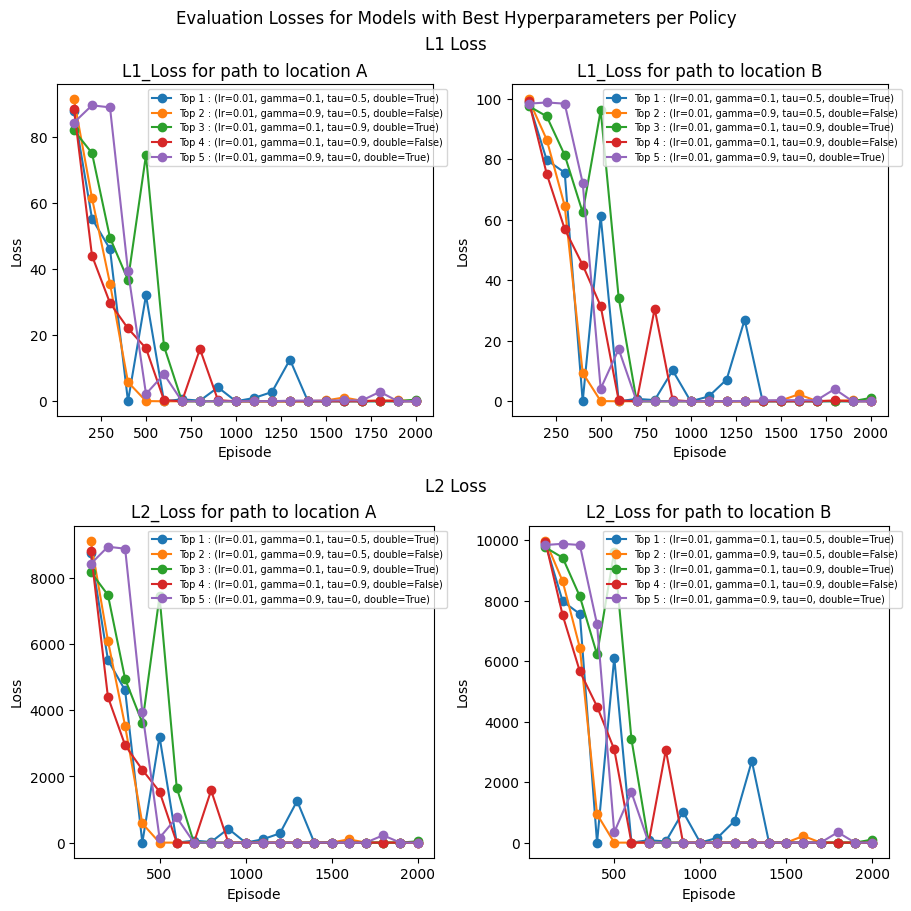

In [3]:
# Only run this cell when you have the file prepared
hyperparam_search(load_from="hyperparam_search_res.pkl")

## Grid Size Testing

To show that our solution is adaptable to different sized grid worlds, below we have trained a separate model for the following grid world sizes:
- (3,3)
- (5,5)
- (6,6)

Finally, we plot the losses for all 3 grid sizes and as expected, the larger the grid world the more the initial loss, and the slower the convergence, although there is a clear downward trend in all the grid worlds, proving that our method clearly learns even with different grid sizes.

*NOTE: we found that the update_interval is very important in determining convergence speed, the larger the grid world, the larger the update_interval needs to be in order for the model to converge. This makes sense because if the grid world is large, the prediction network should get the chance to explore many situations and update many times to reach a stable state before copying its weights over to the target network, otherwise we might run into situations where we are moving the goal post to a bad position which is difficult to recover from.*

For 3x3 grid worlds, the agent learns quickly and the loss stays at 0, for larger sized grid worlds we see that the loss reaches 0 as well, typically at a slower rate but that there are large spikes due to moving goalpost (these spikes are larger for larger gridsizes), though they all eventually converge, showing that our model is generalizable to different grid worlds.


For more details, please refer to the implementation:
- `test_grids` (function to perform model training and evaluation on different grid sizes) located [**here**](modules/grid_test.py)

In [25]:
from modules.grid_test import test_grids

[(3, 3), (5, 5), (6, 6)]
testing with grid size: (3, 3)
=====EVALUATION AT EPISODE 100: REWARD=-9921.564=====
====EVALUATION AT EPISODE 100: LOSS=L1_Loss, VALUE=(79.512, 98.4)=====
====EVALUATION AT EPISODE 100: LOSS=L2_Loss, VALUE=(7940.224, 9840.0)=====
=====EVALUATION AT EPISODE 200: REWARD=-9717.078=====
====EVALUATION AT EPISODE 200: LOSS=L1_Loss, VALUE=(75.312, 96.4)=====
====EVALUATION AT EPISODE 200: LOSS=L2_Loss, VALUE=(7520.224, 9640.0)=====
=====EVALUATION AT EPISODE 300: REWARD=-9803.072=====
====EVALUATION AT EPISODE 300: LOSS=L1_Loss, VALUE=(79.2, 97.2)=====
====EVALUATION AT EPISODE 300: LOSS=L2_Loss, VALUE=(7920.0, 9720.0)=====
=====EVALUATION AT EPISODE 400: REWARD=-9256.324=====
====EVALUATION AT EPISODE 400: LOSS=L1_Loss, VALUE=(66.968, 91.836)=====
====EVALUATION AT EPISODE 400: LOSS=L2_Loss, VALUE=(6680.336, 9180.072)=====
=====EVALUATION AT EPISODE 500: REWARD=-8300.136=====
====EVALUATION AT EPISODE 500: LOSS=L1_Loss, VALUE=(50.2, 82.4)=====
====EVALUATION AT EPI

=====EVALUATION AT EPISODE 300: REWARD=-9970.294=====
====EVALUATION AT EPISODE 300: LOSS=L1_Loss, VALUE=(63.208, 88.804)=====
====EVALUATION AT EPISODE 300: LOSS=L2_Loss, VALUE=(6320.032, 8880.008)=====
=====EVALUATION AT EPISODE 400: REWARD=-9348.762=====
====EVALUATION AT EPISODE 400: LOSS=L1_Loss, VALUE=(51.6, 83.6)=====
====EVALUATION AT EPISODE 400: LOSS=L2_Loss, VALUE=(5160.0, 8360.0)=====
=====EVALUATION AT EPISODE 500: REWARD=-10198.95=====
====EVALUATION AT EPISODE 500: LOSS=L1_Loss, VALUE=(58.4, 91.0)=====
====EVALUATION AT EPISODE 500: LOSS=L2_Loss, VALUE=(5840.0, 9100.0)=====
=====EVALUATION AT EPISODE 600: REWARD=14.256=====
====EVALUATION AT EPISODE 600: LOSS=L1_Loss, VALUE=(0.032, 0.008)=====
====EVALUATION AT EPISODE 600: LOSS=L2_Loss, VALUE=(0.064, 0.016)=====
=====EVALUATION AT EPISODE 700: REWARD=-367.524=====
====EVALUATION AT EPISODE 700: LOSS=L1_Loss, VALUE=(1.264, 3.42)=====
====EVALUATION AT EPISODE 700: LOSS=L2_Loss, VALUE=(120.256, 340.056)=====
=====EVALUATI

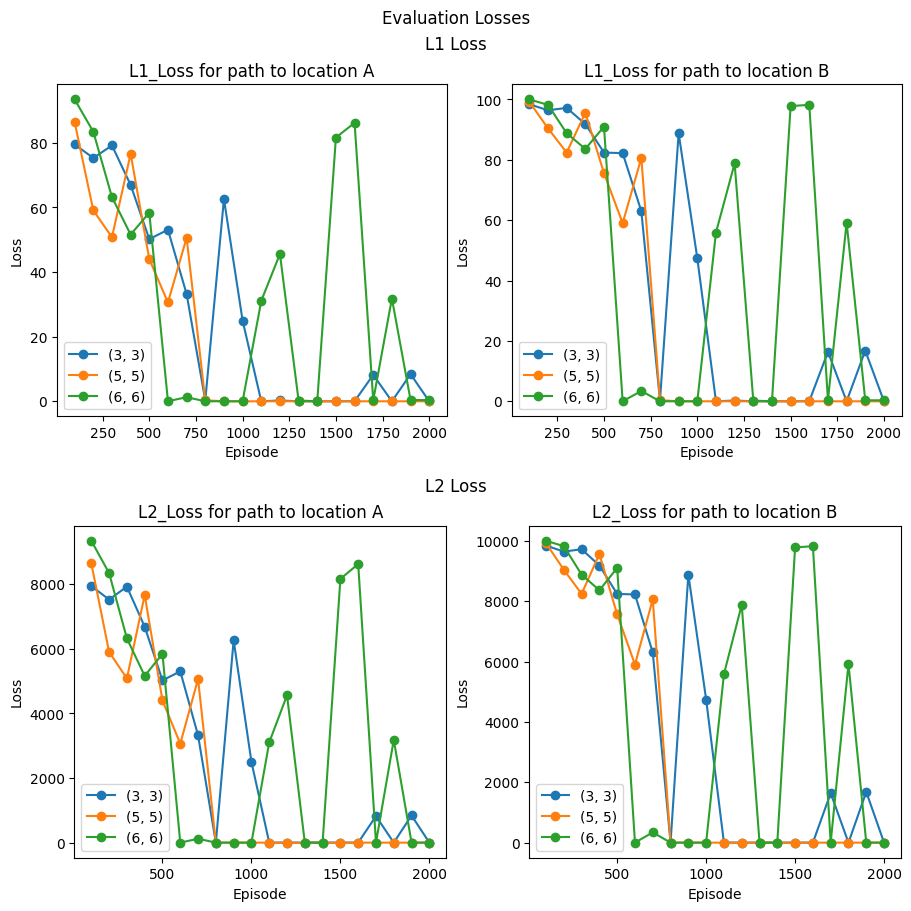

In [26]:
results_grid = test_grids(save_to="grid_test.pkl", verbose=1)

To further prove this generalization to other grid world sizes, below we plot the policy visualization and agent path animation (for a random first and last evaluation episode) for all the grid world sizes.

Note: since the agent path animation chooses a random evaluation configuration from the last episode it may not be the same one as the policy plot

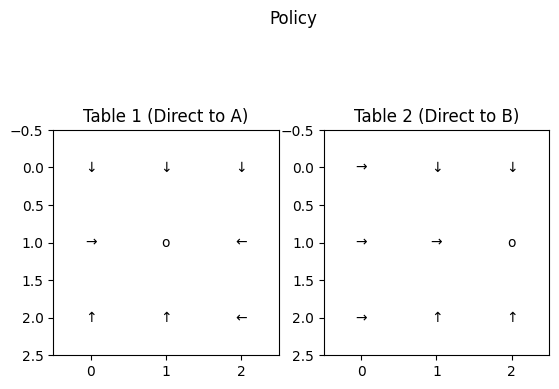

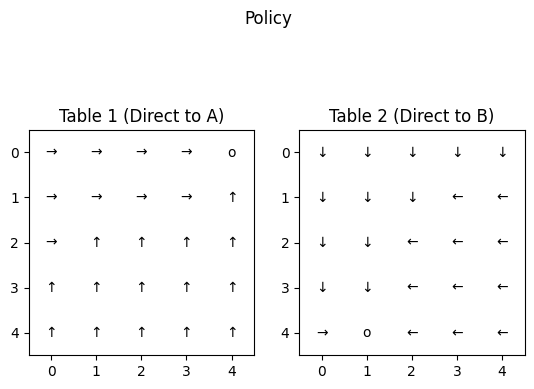

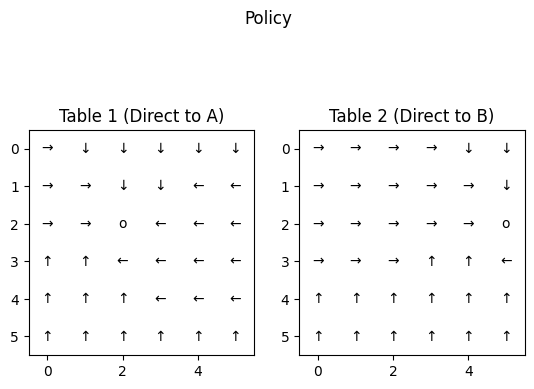

In [27]:
test_grids_viz(results_grid)

## Conclusion

In general, irrespective of the network architectures, the learning of the agent would converge eventually and produce a generalised policy for locating the ideal path to point A followed by point B.

Since we randomly generate the positions of the agent and location A and location B for each episode, and in addition, during evaluation of performance we test for 500 randomly sampled (agent, location A, location B) positions, as can be seen by the decreasing losses and eventual convergence, we have proven that our solution is generalizable to any randomized agent position and/or location A, B.

During the early stages of training, it is observed that the agent's learned policy often contradicts itself, leading to an infinite loop as depicted in the path tracing plot above. This behavior is primarily due to the agent's limited understanding of the environment and its ongoing exploration to determine the best action given a particular state. Consequently, the agent is prone to getting stuck in an infinite loop while exhibiting minimal learning. To address this issue, which commonly arises in the initial evaluation phase, we have implemented a maximum step limit per episode. This limitation serves two purposes: firstly, it resolves the problem of infinite loops, and secondly, it guides the agent's learning process towards minimizing the number of steps taken. The effectiveness and practicality of this technique become evident after approximately 2000 episodes, where the agent successfully locates both point A and B while taking the fewest possible steps.

The policy visualization provided above demonstrates that the agent's learned policy can be effectively applied to different positions of point A and point B. By randomly sampling the locations of point A and point B based on the agent's learning history, we have observed that the policy consistently determines the optimal path to both points A and B, regardless of their specific positions. This adaptability is achieved by structuring the agent's understanding of states. Instead of using the raw position on the grid as the state, we represent the state using Manhattan distance, which creates an afterstate learning effect. This approach allows the agent to perceive the environment in a manner that can be reused across episodes. Through experimentation, we have demonstrated that this technique enhances the agent's learning process compared to a simple state space that relies solely on grid positions. The use of Manhattan distance as a representation of state enables the agent to learn more effectively and generate better policies.

Through the implementation of different techniques to structure the reward function, it has been observed that setting the TARGET REWARD to 1 and the BASE REWARD to -1 yields favorable results. However, by increasing the TARGET REWARD, the agent becomes more motivated to navigate towards points A and B. This leads to faster convergence, as demonstrated in the visualizations above. After approximately 2000 episodes, the target policy shows significant convergence and can be effectively applied to various grid configurations, as long as there is no overlap between the agent, point A, and point B. This adaptability of the policy allows for efficient navigation towards the desired points, further enhancing the overall performance of the agent. 

Although the results presented above are promising, it is important to note a distinction between the tabular method and the stochastic gradient descent method. Unlike the tabular approach, the stochastic gradient descent method may lead the agent to become trapped in a local optimal policy after convergence, rather than achieving the global optimal policy that applies to all grid configurations. This realization comes from observing instances where the policy at certain grids does not align with the ideal path, resulting in a greater loss of reward. However, this behavior is acceptable considering the fundamental differences between the tabular method and neural network-based approaches. In the neural network, a single change in the neurons can have simultaneous effects on multiple states and actions. Additionally, the introduction of non-linearity in the network's structure leads to a loss function with a more complex surface curve, which can trap the optimization process in local optima.

Based on the loss plots, it is evident that the Dueling architecture achieves faster convergence compared to the standard Deep Q-Network (DQN) at early stage when using the same hyperparameter configurations. However, it should be noted that there are occasional spikes in the loss values during training, particularly in the Dueling architecture. These spikes can be attributed to the utilization of v-values to estimate q-values for each action. When the agent encounters experiences that have not been seen before, the estimation of q-values using v-values may be inaccurate, leading to higher loss values. Another potential factor contributing to the occasional spike in loss values is the synchronization of the target network with the prediction network. When the weights of the target network are updated to match those of the prediction network, the prediction of v-values can become unstable in relation to the new target, resulting in higher computed loss values. Nevertheless, both approaches ultimately converge with loss values approaching zero. It is worth noting that the standard DQN exhibits greater stability compared to the Dueling architecture under the tested configurations.

During the tests conducted on different grid sizes, it was observed that as the number of states increased proportionally with the grid size, the learning process became increasingly unstable. This instability can be attributed to the fact that a single neuron is responsible for handling a larger number of states, which scales with the total number of states in the grid. However, despite this initial instability, it was observed that the learning process eventually converged regardless of the grid size, as long as the hyperparameter configurations were set correctly. For instance, in the case of a grid size of (5, 5), it was found that a target network update interval of 150 resulted in stable convergence. On the other hand, when the hyperparameter configurations were incorrect, such as in the case of a grid size of (6, 6), the learning process exhibited drastic fluctuations and struggled to accurately estimate the q-values. In summary, while larger grid sizes pose challenges in terms of stability due to the increased number of states assigned to each neuron, the learning process can still converge successfully with the appropriate hyperparameter configurations.

During the testing of hyperparameters, two main factors were identified as contributing to stable learning. Firstly, it was observed that using a soft-update approach with a high value of tau, such as 0.9, resulted in a more stable learning process. Soft-update involves proportionally updating the weights of the target network towards the weights of the prediction network, based on the value of tau. By having a smaller update in the weights of the target network, over-optimistic estimations that could lead to instability are avoided. Secondly, the utilization of a double Q-Network was found to enhance the stability of the training process. With a double Q-Network, the training process exhibited a stable decrease in loss values without experiencing sudden fluctuations. This stability is attributed to the unbiased estimator provided by the double Q-Network, which allows for a better approximation of the q-values. In summary, using a high tau value for soft-updates and implementing a double Q-Network both contribute to stable learning. These approaches help prevent over-optimistic estimations and provide an unbiased estimator, respectively, resulting in a more stable and reliable training process.

In summary, our agent successfully learned the environment and generated a proficient policy for locating both point A and point B. However, to ensure adaptability to different environments, it is necessary to adjust the training configurations in order to achieve better stability and faster convergence in the learning process. This need for adaptability arises from the inherent instability of estimating an approximation of the target value using gradient descent methods. Although we tested various techniques to enhance stability and convergence rates, the learning process is still significantly influenced by the simplicity of the model architecture used in the experiment. Without the incorporation of any regularization techniques, the learning process lacks additional stabilization measures. Therefore, to further improve stability and convergence, it is recommended to explore the implementation of regularization techniques in the model architecture. This would help mitigate the instability associated with estimating target values and enhance the overall learning performance.